<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/HT_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

from google.colab import files
files.upload()  # Upload your kaggle.json file

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [9]:
# Imports
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Ensure this is imported
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset setup
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}
IMG_SIZE = 224

X, y = [], []

# Load and preprocess
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation (Reduced)
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced range
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,  # Reduced zoom range
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Load base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-10]:  # Unfreeze the last 10 layers instead of 20
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Reduced dropout
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduced dropout
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile with a slightly higher learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Increased learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Reduced patience to allow faster convergence
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Decreased factor
    patience=3,  # Increased patience
    verbose=1,
    min_lr=1e-6
)

# Train with adjusted parameters
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.3969 - loss: 1.7750 - val_accuracy: 0.7100 - val_loss: 0.8943 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7576 - loss: 0.7642 - val_accuracy: 0.7600 - val_loss: 0.7810 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8250 - loss: 0.5211 - val_accuracy: 0.7600 - val_loss: 0.7222 - learning_rate: 0.0010
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.8152 - loss: 0.6242 - val_accuracy: 0.7600 - val_loss: 0.7246 - learning_rate: 0.0010
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8288 - loss: 0.6119 - val_accuracy: 0.7600 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8574 - loss: 0.4834
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.8575 - loss: 0.4840 - val_accuracy: 0.

In [10]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n🌟 Final Test Accuracy: {accuracy:.2f}")
print(f"📉 Final Test Loss: {loss:.4f}")

# Save the model
model.save("efficientnetb0_ovarian_model.keras")
print("✅ Model saved successfully!")


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8265 - loss: 0.6893

🌟 Final Test Accuracy: 0.85
📉 Final Test Loss: 0.6320
✅ Model saved successfully!


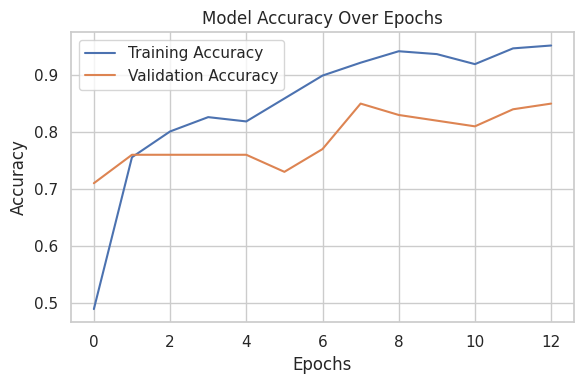

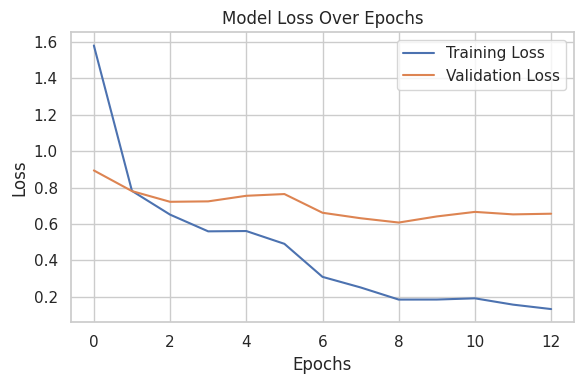

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')  # for prettier seaborn plots
plt.figure(figsize=(6, 4))
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label='Training Accuracy')
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
